## Installing necessary packages

In [ ]:
!pip install gif2numpy
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gif2numpy: filename=gif2numpy-1.3-py2.py3-none-any.whl size=8392 sha256=6c47781acdd9d144608139885206e6b88c2c24dfed4db6c0c98fd15a7e8c98cf
  Stored in directory: /root/.cache/pip/wheels/7d/70/75/7e42205c427015e223944d47ea89e01dc779fb49ba664fb743
Successfully built gif2numpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 43.6 MB/s eta 0:00:00


## Importing necessary packages

In [ ]:
import os
from pathlib import Path
from google.colab import drive

import cv2
import gif2numpy
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import yaml
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.transform import Affine
from yaml.loader import SafeLoader

## Defining necessary constants

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = Path("./drive/MyDrive/EDISS_winter_school/data/aemet/10min")
YAML_PATH = Path("./drive/MyDrive/EDISS_winter_school/radars.yaml")

PALMA_DATASET_PATH = DATASET_PATH / "pm"
VALENCIA_DATASET_PATH = DATASET_PATH / "va"
BARCELONA_DATASET_PATH = DATASET_PATH / "ba"

## Digitizing the dataset

In [ ]:
with open(YAML_PATH, 'r') as f:
  data = yaml.load(f, Loader=SafeLoader)

In [ ]:
palma_location_data = data["data"]["PM"]
valencia_location_data = data["data"]["VA"]
barcelona_location_data = data["data"]["BA"]
barcelona_location_data

{'rdr_code': 'ba',
 'latitude': 41.4082,
 'longitude': 1.88499,
 'radius': 240,
 'name': 'Barcelona'}

In [ ]:
def create_circular_mask(width, height):
  center = (int(width/2), int(height/2))
  radius = min(center[0], center[1], width - center[0], height - center[1])

  Y, X = np.ogrid[:height, :width]
  dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

  mask = dist_from_center <= radius
  return mask

def read_gif(gif_path):
  np_frames, _, image_specs = gif2numpy.convert(gif_path)
  image = np_frames[0]
  _, dim, _ = image.shape
  image = image[:dim, :, ::-1]
  height, width, _ = image.shape

  mask = create_circular_mask(width, height)
  image[~mask] = 0

  return image

In [ ]:
def numpy2tiff(location_data, image, file_path):
  center_longitude, center_latitude = location_data["longitude"], location_data["latitude"]
  radius = location_data["radius"] * 1000

  height, width, _ = image.shape

  x = np.arange(0, width, 1)
  y = np.arange(0, height, 1)

  latitudes = center_latitude + (height/2 - y) * 1 / 110.574
  longitudes = center_longitude - (width/2 - x) * 1 / (111.320 * np.cos(latitudes * np.pi / 180))

  xres = (longitudes[-1] - longitudes[0]) / len(longitudes)
  yres = (latitudes[-1] - latitudes[0]) / len(latitudes)

  transform = Affine.translation(longitudes[0] - xres/2, latitudes[0] - yres/2) * Affine.scale(xres, yres)

  parent_folder = '/'.join(file_path.split('/')[:-1])

  if not os.path.exists(parent_folder):
    os.makedirs(parent_folder)

  with rasterio.open(
    file_path,
    mode='w',
    driver="GTiff",
    height=height,
    width=width,
    count=3,
    dtype=image.dtype,
    crs="+proj=latlong",
    transform=transform
  ) as f:
    f.write(image[:, :, 0], 1)
    f.write(image[:, :, 1], 2)
    f.write(image[:, :, 2], 3)

In [ ]:
datasets = {
  "PALMA": {
    "dataset_path": PALMA_DATASET_PATH,
    "location_data": palma_location_data,
    "result_folder": "./drive/MyDrive/DNA_Hackathon/PALMA/"
  },
  "VALENCIA": {
    "dataset_path": VALENCIA_DATASET_PATH,
    "location_data": valencia_location_data,
    "result_folder": "./drive/MyDrive/DNA_Hackathon/VALENCIA/"
  },
  "BARCELONA": {
    "dataset_path": BARCELONA_DATASET_PATH,
    "location_data": barcelona_location_data,
    "result_folder": "./drive/MyDrive/DNA_Hackathon/BARCELONA/"
  }
}

region = "PALMA"
dataset = datasets[region]

for day_folder_name in sorted(os.listdir(dataset["dataset_path"])):
  day_folder_path = dataset["dataset_path"] / day_folder_name

  if day_folder_name == ".DS_Store":
    continue

  for image_name in sorted(os.listdir(day_folder_path)):
    gif_path = day_folder_path / image_name
    
    result_path = dataset["result_folder"] + os.path.splitext(image_name)[0] + ".tif"
    
    image = read_gif(gif_path)
    numpy2tiff(dataset["location_data"], image, result_path)

    break

  break

## Merging images together

In [ ]:
palma_image = rasterio.open(datasets["PALMA"]["result_folder"] + "/aemet_pm_202201010000.tif")
barcelona_image = rasterio.open(datasets["BARCELONA"]["result_folder"] + "/aemet_ba_202201010000.tif")
valencia_image = rasterio.open(datasets["VALENCIA"]["result_folder"] + "/aemet_va_202201010000.tif")

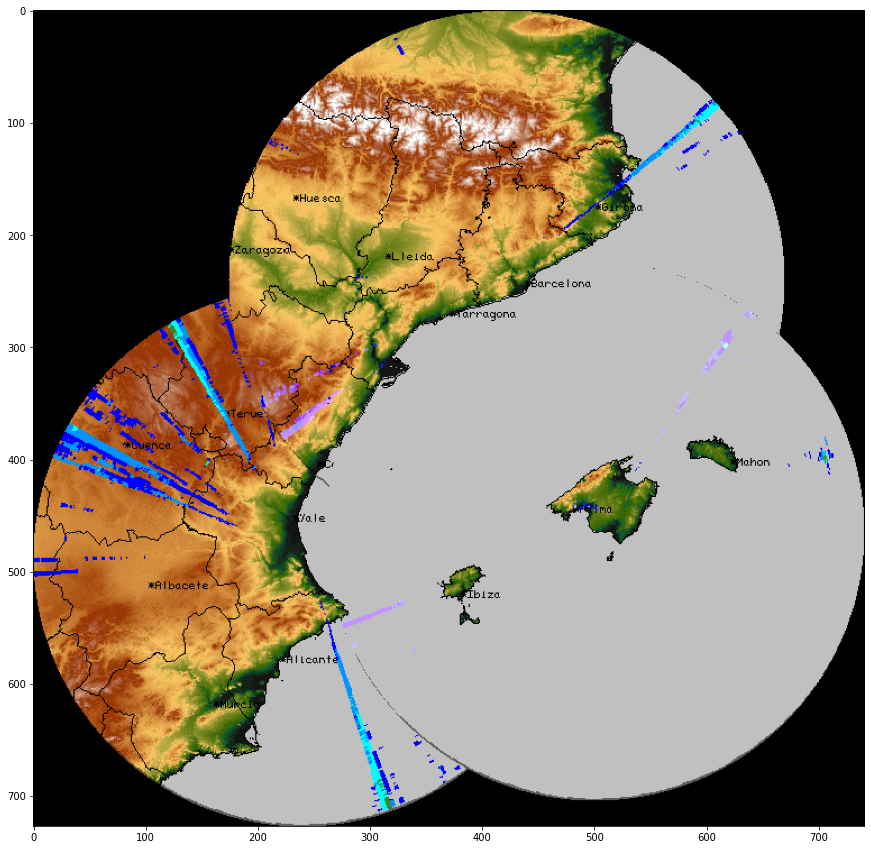

In [ ]:
images = [palma_image, barcelona_image, valencia_image]

mosaic, output = merge(images)

fig, ax = plt.subplots(figsize=(15, 15))
show(mosaic)

## Saving in netCDF format

In [ ]:
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass

In [ ]:
from netCDF4 import Dataset, date2num

ncfile = Dataset("./drive/MyDrive/DNA_Hackathon/result.nc", mode='w', format="NETCDF4_CLASSIC")
print(ncfile)

PermissionError: ignored

In [ ]:
lat_limit = mosaic.shape[1]
lon_limit = mosaic.shape[2]

lat_dim = ncfile.createDimension("lat", lat_limit)
lon_dim = ncfile.createDimension("lon", lon_limit)
time_dim = ncfile.createDimension("time", None)

for dim in ncfile.dimensions.items():
  print(dim)

('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 727)
('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 741)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)


In [ ]:
ncfile.title = "Inference"
ncfile.subtitle = "May results"

In [ ]:
lat = ncfile.createVariable("lat", np.float32, ("lat",))
lat.units = "degrees_north"
lat.long_name = "latitude"

lon = ncfile.createVariable("lon", np.float32, ("lon",))
lon.units = "degrees_east"
lon.long_name = "longitude"

time = ncfile.createVariable("time", np.float64, ("time",))
time.units = "hours since 1800-01-01"
time.long_name = "time"

rain = ncfile.createVariable("rain", np.float64, ("time", "lat", "lon"))
rain

<class 'netCDF4._netCDF4.Variable'>
float64 rain(time, lat, lon)
unlimited dimensions: time
current shape = (0, 727, 741)
filling on, default _FillValue of 9.969209968386869e+36 used

In [ ]:
print("-- Some pre-defined attributes for variable rain:")
print("temp.dimensions:", rain.dimensions)
print("temp.shape:", rain.shape)
print("temp.dtype:", rain.dtype)
print("temp.ndim:", rain.ndim)

-- Some pre-defined attributes for variable rain:
temp.dimensions: ('time', 'lat', 'lon')
temp.shape: (0, 727, 741)
temp.dtype: float64
temp.ndim: 3


In [ ]:
all_bounds = []

for image in images:
  left, bottom, right, top = image.bounds
  all_bounds.append([left, bottom, right, top])
  
all_bounds = np.array(all_bounds)

min_lon = all_bounds[:, 0].min()
max_lon = all_bounds[:, 2].max()
min_lat = all_bounds[:, 1].min()
max_lat = all_bounds[:, 3].max()

In [ ]:
nlats = len(lat_dim)
nlons = len(lon_dim)
ntimes = 3

lat_diff = np.abs(max_lat - min_lat) / nlats
lon_diff = np.abs(max_lon - min_lon) / nlons

lat[:] = max_lat - lat_diff * np.arange(nlats)
lon[:] = min_lon + lon_diff * np.arange(nlons)

rain[0, :, :] = mosaic[0, :, :]

print(rain.shape)
print(rain[:, :, :].min(), rain[:, :, :].max())

(3, 727, 741)
0.0 255.0


In [ ]:
dates = []
times = date2num(dates, time.units)
time[:] = times
ncfile.close()
print("Dataset is closed!")

(3, 727, 741)